In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Part II: the $n$-layer model

Here we will build the n-layer model mentioned in the lecture. We know that introducing layers in the model is to consider the role of atmosphere, especially greenhouse gases. The number of layers is equivalent to the amount of greenhouse gas in the atmosphere.

In [2]:
S = 1370 # Solar constant
albedo = 0.3

In [19]:
# The nlayer model, calculating surface temperature
def nlayer(n,S,albedo,expnt=4):
    '''input:
    n: number of layers
    S: solar constant
    albedo: fraction of reflection
    expnt: exponent in Stefan-Bolztmann's law
    
    Output:
    T: surface temperature'''
    
    sigma = 5.67e-8 #Stefan-Boltzman constant
    # solution of surface temperature
    T = ((n+1)*S*(1-albedo)/(4*sigma))**(1./expnt)
    return T

Let's see how the surface temperature changes as the number of layers increases.

In [20]:
# number of layers
# it is equivalent to the amount of greenhouse gas in the atmosphere
layers = np.arange(100)
T_layer = nlayer(layers,S,albedo,4)

Text(0,0.5,'Surface temperature (K)')

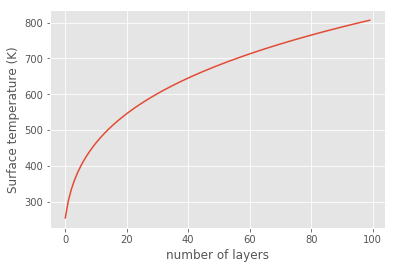

In [21]:
# plot number of layers vs. surface temperature
plt.plot(layers,T_layer)
plt.xlabel('number of layers')
plt.ylabel('Surface temperature (K)')

**Question 1**: How the surface temperature changes as the number of layers increases? Is this reasonable? Why?

**Answer 1**:

We know that the black boday radiation is proportional to the fourth power of temperature ($E=\sigma T^4$). What if we live in a world that the exponent number is not 4?

**Question 2**: What if the exponent number is 2 (i.e. $E=\sigma T^2$)? What is the surface temperature based on this n-layer model (use n=2)?

In [22]:
print('surface temperature=',nlayer(2,S,albedo,?),'K')

SyntaxError: invalid syntax (<ipython-input-22-45fabe9deb4e>, line 1)

We can plot the how surface temperature responses as the power changes

In [10]:
# what if the power number is not 4?
n_power = np.arange(1,7,0.2)
T_power = nlayer(2,S,albedo,n_power) # choose a two-layer model

Text(0,0.5,'Surface temperature (K)')

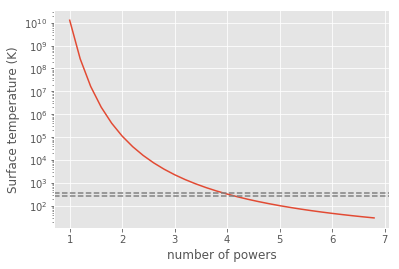

In [18]:
plt.semilogy(n_power,T_power)
plt.axhline(273,color='gray',linestyle='--')
plt.axhline(373,color='gray',linestyle='--')
plt.xlabel('Stefan-Boltzmann Exponent')
plt.ylabel('Surface temperature (K)')

** Question 3**: For what range of exponents do we get a "livable" temperature? (hint: plot 2 horizontal lines at the freezing point and boiling point of water, assuming standard pressure).  


# Part III: A Radiative-Convective Model

0D models, such as the ones we've been playing so far, are instructive but quite limited.

In this part, we will build a 1D climate model, which can simulate the vertical profile of temperature in the atmosphere. At first, we will only consider radiative processes, and then progressively add dry and moist convection processes. This 1D climate model is part of the climlab package (http://climlab.readthedocs.io) developed by Dr. Brian Rose at the University at Albany.

### 1. What are we aiming for?
Let's first look at what the vertical distribution of temperature of the Earth looks like in the observations. Here we use the NCEP/NCAR reanalysis data as the observations.

In [23]:
# import climlab
from __future__ import division, print_function
import xarray as xr
import climlab

# read NCEP/NCAR data
# read temperature, level, and latitude
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset(ncep_url + "pressure/air.mon.1981-2010.ltm.nc")
level = ncep_air.level
lat = ncep_air.lat

ModuleNotFoundError: No module named 'climlab'

Take global averages and time averages.

In [4]:
Tzon = np.mean(ncep_air.variables['air'],axis=(0,3))
Tglobal = np.sum( Tzon * np.cos(np.deg2rad(lat)), axis=1 ) / np.sum( np.cos(np.deg2rad(lat) ) )

In [5]:
q_obs = np.loadtxt('q_profile.txt')

Define functions:
(1) Get the log scale axis of pressure
(2) Get the temperature tendency variables from the model

In [6]:
def zstar(lev):
    return -np.log(lev / climlab.constants.ps)
def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topdown=False):
        if proc.time_type is not 'diagnostic':
            tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
            tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

Text(0.5,1,'Global, annual mean sounding from NCEP Reanalysis')

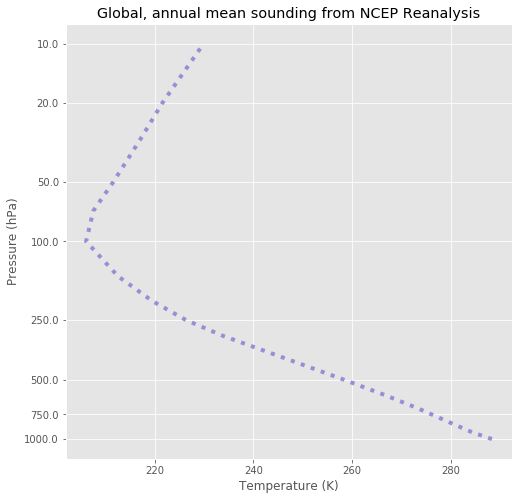

In [7]:
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])

plt.style.use('ggplot')
plt.figure( figsize=(8,8) )
plt.plot( Tglobal + 273.15, zstar(level),label='observations',color='C2',linestyle=':',linewidth=4)
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Global, annual mean sounding from NCEP Reanalysis')

**Question 3**: Please describe the vertical temperature distribution.

**Answer 3**:

### 2. Radiative equilibrium
Now we only use the radiation model (RRTMG) to simulate the temperature profile and compare it with the observation. This model can consider the radiation effect of different gases, at different wavelengths (like CO$_2$ mainly absorbs long-wave radiation, but O$_3$ mainly absorbs short-wave radiation).

In [8]:
#  Choose the surface albedo
alb = 0.2
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=50)
#  Parent model process
rad_model = climlab.TimeDependentProcess(state=state)
#  Set the radiation model
rad = climlab.radiation.RRTMG(state=state, specific_humidity=q_obs, albedo=alb)
#  Couple the radiation model
rad_model.add_subprocess('Radiation', rad)

Getting ozone data from /Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:382: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:163: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):


Let's look at what radiatively active gases are in this model.

In [27]:
#  Volumetric mixing ratios
rad.absorber_vmr

{'CCL4': 0.0,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CH4': 1.65e-06,
 'CO2': 0.000348,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'O3': array([8.49933725e-06, 4.48576690e-06, 2.25137178e-06, 1.13532298e-06,
        6.61862588e-07, 4.41032900e-07, 3.18477002e-07, 2.45552383e-07,
        2.00235820e-07, 1.66251001e-07, 1.37260417e-07, 1.14054576e-07,
        9.29020109e-08, 8.01070865e-08, 6.83827083e-08, 6.34392413e-08,
        5.84957744e-08, 5.57122567e-08, 5.33033466e-08, 5.10772439e-08,
        4.93420300e-08, 4.76068161e-08, 4.60528063e-08, 4.48079957e-08,
        4.35631852e-08, 4.23784162e-08, 4.16341607e-08, 4.08899052e-08,
        4.01456497e-08, 3.94640551e-08, 3.88467978e-08, 3.82295406e-08,
        3.76122833e-08, 3.68509303e-08, 3.59191566e-08, 3.49873829e-08,
        3.40556092e-08, 3.31238355e-08, 3.21055234e-08, 3.10854767e-08,
        3.00654301e-08, 2.90453834e-08, 2.80298557e-08, 2.71984933e-08,
        2.63671309e-08, 2.55357684e-08, 2.47044060e-08, 2.38730436e-08,
    

**Question 4**: What gases are considered in the radiation model?

**Answer 4**:

Let's run this model until it reaches equilibrium (i.e. energy fluxes balance each other out, so the temperature is constant). We need to specify an initial state, which will be an isothermal one (the atmosphere starts out with the same temperature everywhere - obviously not realistic, but instructive to see how radiation changes that situation).

In [9]:
#  Start from isothermal state
rad_model.state.Tatm[:] = rad_model.state.Ts

In [10]:
# Integrate the model for 4 years
rad_model.integrate_years(4)

Integrating for 1460 steps, 1460.9688 days, or 4 years.
Total elapsed time is 3.997347513512951 years.


In [11]:
# Check whether the model reaches the equilibrium
# usually it does when the number smaller than 0.1
rad_model.ASR - rad_model.OLR

Field([-7.12164469e-05])

Now let's get the temperature **tendencies**. A tendency is the rate of change of a quantity due to different processes; in this case radiation (shortwave and longwave) and (later on) convection. This allows us to quantify the contribution of different physical processes to the evolution of temperature: when a process contriutes to warming the atmosphere, its tendency is positive. When it contributes to cooling the atmosphere, its tendency is negative. 

In [12]:
tendencies_atm, tendencies_sfc = get_tendencies(rad_model)

Text(0.5,1,'Temperature tendency of the pure radiation case')

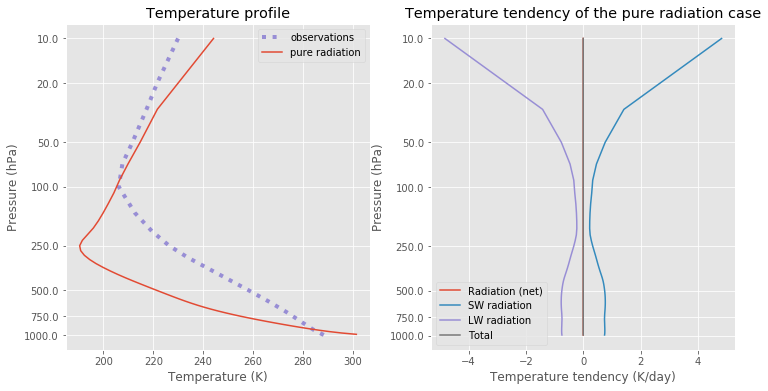

In [13]:
# plot the temperature profile and temperature tendencies

# prepare the legend names of different temperature tendencies
plot_names = {'top': 'Total', 'LW': 'LW radiation',
              'SW': 'SW radiation',
              'Radiation': 'Radiation (net)',
              'Convection': 'Convection'}

plt.style.use('ggplot')
plt.figure( figsize=(12,6) )
# plot the first subplot
plt.subplot(1, 2, 1)
plt.plot( Tglobal + 273.15, zstar(level),label='observations',color='C2',linestyle=':',linewidth=4 )
plt.plot(rad_model.Tatm,zstar(rad_model.lev),label='pure radiation',color='C0')
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature profile')

# plot the second subplot
plt.subplot(1, 2, 2)
for i, name in enumerate(tendencies_atm.data_vars):
    plt.plot(tendencies_atm[name], zstar(rad_model.lev),label=plot_names[name])
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature tendency (K/day)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature tendency of the pure radiation case')

**Question 5**: Compare the temperature profile simulated by the radiation process. What are the main discrepancies? Forcus in particular on the near-surface temperature and lapse rate. 

**Answer 5**:

### 3. adding dry convection
Obviously radiation is not the only important process in the atmosphere. When the air near the surface gets too hot, it wants to rise, which transports heat upwards, thereby reducing the lapse rate. Let's add this dry convection process to the radiative processes seen above, and see how that affects the temperature profile. What follows is some model gobbledygook that specifies convection to work at a dry adibatic lapse rate of 9.8 degrees/km, as seen in class. 

In [14]:
state2 = climlab.column_state(num_lev=50)
#  Parent model process
rcm_dry = climlab.TimeDependentProcess(state=state2)
#  Set the radiation model
rad_dry = climlab.radiation.RRTMG(state=state2, specific_humidity=q_obs, albedo=alb)
#  Convective adjustment
conv_dry = climlab.convection.ConvectiveAdjustment(state=state2, adj_lapse_rate=9.8)
#  Couple everything together
rcm_dry.add_subprocess('Radiation', rad_dry)
rcm_dry.add_subprocess('Convection', conv_dry)

Getting ozone data from /Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:382: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:163: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):


In [15]:
rcm_dry.state.Tatm[:] = rcm_dry.state.Ts
rcm_dry.integrate_years(4)
rcm_dry.ASR - rcm_dry.OLR

Integrating for 1460 steps, 1460.9688 days, or 4 years.
Total elapsed time is 3.997347513512951 years.


Field([-5.72331379e-06])

OK, great, the model reaches equilibrium. Now let's see what the temperature tendencies look like:

In [16]:
tendencies_atm, tendencies_sfc = get_tendencies(rcm_dry)

Text(0.5,1,'Temperature tendency of the dry adjustment case')

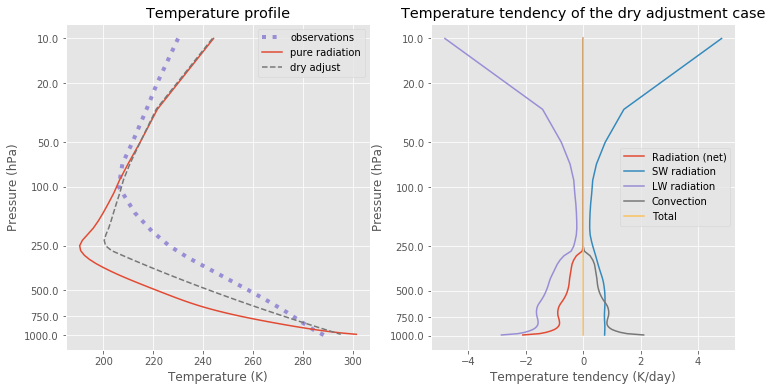

In [17]:
plt.style.use('ggplot')
plt.figure( figsize=(12,6) )
plt.subplot(1, 2, 1)
plt.plot( Tglobal + 273.15, zstar(level),label='observations',color='C2',linestyle=':',linewidth=4 )
plt.plot(rad_model.Tatm,zstar(rad_model.lev),label='pure radiation',color='C0')
plt.plot(rcm_dry.Tatm,zstar(rad_model.lev),label='dry adjust',color='C3',linestyle='--')
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature profile')

plt.subplot(1, 2, 2)
for i, name in enumerate(tendencies_atm.data_vars):
    plt.plot(tendencies_atm[name], zstar(rad_model.lev),label=plot_names[name])
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature tendency (K/day)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature tendency of the dry adjustment case')

**Question 6**: Does adding the dry convection process improve the simulation of vertical temperature profile? Look at the temperature tendencies, what's the role of convection process? At what level does this role stop, and why do you think that is?

**Answer 6**:

### 4. Adding moist convection

Dry convection is fine and good, but in the real world there is often moisture, which condenses once the temperature gets cold enough, so that changes the game. How so? Let us see. We start with some model gobbledygook to set things up proper, then we run the model for 4 years, so it has a chance to reach equilibrium.

In [18]:
state3 = climlab.column_state(num_lev=50)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state3)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state3)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state3, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state3, adj_lapse_rate=6)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)

Getting ozone data from /Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:382: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/climlab/process/process.py:163: FutureWarning: Conversion of the second argument of issubdtype from `'int'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype('int').type`.
  if np.issubdtype(self.state[name].dtype, 'int'):


In [19]:
rcm.state.Tatm[:] = rcm.state.Ts
rcm.integrate_years(4)
rcm.ASR - rcm.OLR

Integrating for 1460 steps, 1460.9688 days, or 4 years.
Total elapsed time is 3.997347513512951 years.


Field([1.86313603e-05])

In [20]:
tendencies_atm, tendencies_sfc = get_tendencies(rcm)

Text(0.5,1,'Temperature tendency of the moist adjustment case')

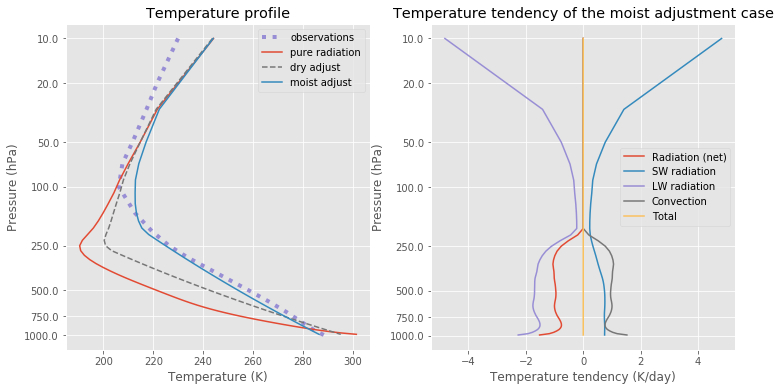

In [21]:
plt.style.use('ggplot')
plt.figure( figsize=(12,6) )
plt.subplot(1, 2, 1)
plt.plot( Tglobal + 273.15, zstar(level),label='observations',color='C2',linestyle=':',linewidth=4 )
plt.plot(rad_model.Tatm,zstar(rad_model.lev),label='pure radiation',color='C0')
plt.plot(rcm_dry.Tatm,zstar(rad_model.lev),label='dry adjust',color='C3',linestyle='--')
plt.plot(rcm.Tatm,zstar(rcm.lev),label='moist adjust',color='C1')
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature profile')

plt.subplot(1, 2, 2)
for i, name in enumerate(tendencies_atm.data_vars):
    plt.plot(tendencies_atm[name], zstar(rad_model.lev),label=plot_names[name])
plt.legend()
plt.yticks(zstar(yticks),yticks)
plt.xlabel('Temperature tendency (K/day)')
plt.ylabel('Pressure (hPa)')
plt.title('Temperature tendency of the moist adjustment case')

**Question 7**: Does adding the moist convection process improve the simulation of vertical temperature profile? Look at the temperature tendency due to convection. Is it larger compared to the dry convection case? What is the possible explanation for this?

**Answer 7**:

**Question 8**: In conclusion, comment on the logic of reasoning with computer-based models (sometimes called "experiments *in silico*", because the heart of these machines is made of silicon). What do they allow us to do that we wouldn't be able to do otherwise? 

**Answer 8**: 